In [1]:
!pip install pandas==2.2.2


In [2]:
!pip install wfdb --no-deps

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install mlflow

In [5]:
# STEP 0: Install Required Packages
!pip install wfdb mlflow

# STEP 1: Imports
import wfdb
import os
import numpy as np
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# STEP 2: Preprocessing Functions
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def zscore_normalize(signal):
    scaler = StandardScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

def preprocess_ecg_windows(raw_windows, fs=100):
    processed = []
    for window in raw_windows:
        filtered = bandpass_filter(window, fs=fs)
        normalized = zscore_normalize(filtered)
        reshaped = normalized.reshape(-1, 1)
        processed.append(reshaped)
    return np.array(processed)

# STEP 3: Load Apnea-ECG Records
def load_apnea_ecg_windows(data_path):
    record_names = [f"{prefix}{str(i).zfill(2)}" for prefix in ["a", "b", "c"]
                    for i in range(1, 21)
                    if not (prefix == "b" and i > 5) and not (prefix == "c" and i > 10)]

    data_windows = []
    labels = []

    for rec in record_names:
        try:
            print(f"Processing {rec}...")
            base_path = os.path.join(data_path, rec)
            record = wfdb.rdrecord(base_path)
            signal = record.p_signal[:, 0]
            fs = int(record.fs)

            ann = wfdb.rdann(base_path, 'apn')
            apn_labels = ann.aux_note
            total_minutes = len(signal) // (60 * fs)

            if total_minutes != len(apn_labels):
                print(f"Label mismatch in {rec}. Skipping.")
                continue

            for i in range(total_minutes):
                start = i * 60 * fs
                end = (i + 1) * 60 * fs
                segment = signal[start:end]

                if len(segment) == 60 * fs:
                    label = 1 if apn_labels[i].strip() == '(Apnea)' else 0
                    data_windows.append(segment)
                    labels.append(label)

        except Exception as e:
            print(f"Error in {rec}: {e}")

    print(f"\n✅ Extracted {len(data_windows)} labeled segments.")
    return data_windows, labels

# STEP 4: Define the CNN Model
def build_1d_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 5, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# STEP 5: Load, Preprocess, Train, and Evaluate
data_path = '/content/drive/MyDrive/apnea-ecg-database-1.0.0/'

# Load data
raw_windows, raw_labels = load_apnea_ecg_windows(data_path)

# Preprocess
X_ready = preprocess_ecg_windows(raw_windows)
y_ready = np.array(raw_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y_ready, test_size=0.2, random_state=42)

# Build model
model = build_1d_cnn((6000, 1))

# MLflow tracking
mlflow.set_experiment("Apnea_ECG_CNN")
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
Processing a01...
Label mismatch in a01. Skipping.
Processing a02...
Label mismatch in a02. Skipping.
Processing a03...
Label mismatch in a03. Skipping.
Processing a04...
Label mismatch in a04. Skipping.
Processing a05...
Label mismatch in a05. Skipping.
Processing a06...
Label mismatch in a06. Skipping.
Processing a07...
Label mismatch in a07. Skipping.
Processing a08...
Label mismatch in a08. Skipping.
Processing a09

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/15 17:36:24 INFO mlflow.tracking.fluent: Experiment with name 'Apnea_ECG_CNN' does not exist. Creating a new experiment.


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9031 - loss: 0.0859

40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 549ms/step - accuracy: 0.9049 - loss: 0.0843 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 429ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 616ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 424ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 417ms/step - a

In [ ]:
# Easy-MobileNetV2-Inspired 1D CNN for Sleep Apnea Detection (Simplified)
# Reference: https://github.com/mindspore-lab/models/tree/master/research/arxiv_papers/Easy-MobileNetV2/code

# STEP 0: Install dependencies (run in notebook/Colab shell before this script)
# !pip install wfdb mlflow

import os
import wfdb
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from scipy.signal import butter, filtfilt
import mlflow
import mlflow.tensorflow

# 1. Bandpass filter
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# 2. Z-score normalization
def zscore_normalize(signal):
    scaler = StandardScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

# 3. Preprocessing pipeline
def preprocess_ecg_windows(raw_windows, fs=100):
    processed = []
    for window in raw_windows:
        filtered = bandpass_filter(window, fs=fs)
        normalized = zscore_normalize(filtered)
        reshaped = normalized.reshape(-1, 1)
        processed.append(reshaped)
    return np.array(processed)

# 4. Load data from PhysioNet Apnea-ECG Database
def load_apnea_ecg_windows(data_path):
    record_names = [f"a{str(i).zfill(2)}" for i in range(1, 21)] + \
                   [f"b{str(i).zfill(2)}" for i in range(1, 6)] + \
                   [f"c{str(i).zfill(2)}" for i in range(1, 11)]
    data_windows = []
    labels = []
    for rec in record_names:
        try:
            base_path = os.path.join(data_path, rec)
            record = wfdb.rdrecord(base_path)
            signal = record.p_signal[:, 0]
            fs = int(record.fs)
            ann = wfdb.rdann(base_path, 'apn')
            apn_labels = ann.symbol
            total_minutes = len(signal) // (60 * fs)
            valid_minutes = min(total_minutes, len(apn_labels))
            for i in range(valid_minutes):
                start = i * 60 * fs
                end = (i + 1) * 60 * fs
                segment = signal[start:end]
                if len(segment) == 60 * fs:
                    label = 1 if apn_labels[i].strip().upper() == 'A' else 0
                    data_windows.append(segment)
                    labels.append(label)
        except Exception as e:
            print(f"Error in {rec}: {e}")
    return data_windows, labels

# 5. Define simplified MobileNetV2-like 1D CNN
class EasyMobileNetV2(tf.keras.Model):
    def __init__(self, input_shape):
        super(EasyMobileNetV2, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=input_shape)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dwconv = tf.keras.layers.DepthwiseConv1D(3, padding='same', activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pwconv = tf.keras.layers.Conv1D(32, 1, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.dwconv(x)
        x = self.bn2(x)
        x = self.pwconv(x)
        x = self.global_pool(x)
        return self.classifier(x)

# 6. Main pipeline
if __name__ == "__main__":
    data_path = "/content/drive/MyDrive/apnea-ecg-database-1.0.0/"
    raw_windows, raw_labels = load_apnea_ecg_windows(data_path)
    X = preprocess_ecg_windows(raw_windows)
    y = np.array(raw_labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model = EasyMobileNetV2((6000, 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    mlflow.set_experiment("EasyMobileNetV2_Apnea")
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/13 19:56:29 INFO mlflow.tracking.fluent: Experiment with name 'EasyMobileNetV2_Apnea' does not exist. Creating a new experiment.
2025/05/13 19:56:29 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'EasyMobileNetV2' object has no attribute 'input_shape'


Epoch 1/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6136 - loss: 0.6705

426/426 ━━━━━━━━━━━━━━━━━━━━ 107s 241ms/step - accuracy: 0.6137 - loss: 0.6705 - val_accuracy: 0.6182 - val_loss: 0.6390
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6434 - loss: 0.6159

426/426 ━━━━━━━━━━━━━━━━━━━━ 128s 210ms/step - accuracy: 0.6434 - loss: 0.6158 - val_accuracy: 0.6954 - val_loss: 0.5771
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6949 - loss: 0.5692

426/426 ━━━━━━━━━━━━━━━━━━━━ 143s 212ms/step - accuracy: 0.6949 - loss: 0.5692 - val_accuracy: 0.7048 - val_loss: 0.5632
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7077 - loss: 0.5577

426/426 ━━━━━━━━━━━━━━━━━━━━ 143s 215ms/step - accuracy: 0.7077 - loss: 0.5577 - val_accuracy: 0.7333 - val_loss: 0.5502
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7330 - loss: 0.5492

426/426 ━━━━━━━━━━━━━━━━━━━━ 139s 208ms/step - accuracy: 0.7330 - loss: 0.5492 - val_accuracy: 0.7181 - val_loss: 0.5422
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7372 - loss: 0.5379

426/426 ━━━━━━━━━━━━━━━━━━━━ 143s 211ms/step - accuracy: 0.7372 - loss: 0.5379 - val_accuracy: 0.7507 - val_loss: 0.5337
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7429 - loss: 0.5329

426/426 ━━━━━━━━━━━━━━━━━━━━ 144s 215ms/step - accuracy: 0.7429 - loss: 0.5329 - val_accuracy: 0.7554 - val_loss: 0.5269
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7499 - loss: 0.5259

426/426 ━━━━━━━━━━━━━━━━━━━━ 138s 205ms/step - accuracy: 0.7499 - loss: 0.5259 - val_accuracy: 0.7416 - val_loss: 0.5221
Epoch 9/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7445 - loss: 0.5269

426/426 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.7445 - loss: 0.5269 - val_accuracy: 0.7492 - val_loss: 0.5197
Epoch 10/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7492 - loss: 0.5182

426/426 ━━━━━━━━━━━━━━━━━━━━ 91s 214ms/step - accuracy: 0.7492 - loss: 0.5182 - val_accuracy: 0.7612 - val_loss: 0.5178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


2025/05/13 20:18:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0rq_v1cr/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      2103
           1       0.70      0.66      0.68      1302

    accuracy                           0.76      3405
   macro avg       0.75      0.74      0.74      3405
weighted avg       0.76      0.76      0.76      3405

Accuracy: 0.7612334801762115


✅ Extracted: 17023 segments | Labels: Counter({0: 10512, 1: 6511})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/15 17:41:44 INFO mlflow.tracking.fluent: Experiment with name 'EasyMobileNetV2_Apnea' does not exist. Creating a new experiment.
2025/05/15 17:41:44 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'EasyMobileNetV2' object has no attribute 'input_shape'


Epoch 1/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6192 - loss: 0.6666
Epoch 1: val_accuracy improved from -inf to 0.61762, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6192 - loss: 0.6666 - val_accuracy: 0.6176 - val_loss: 0.6562
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6180 - loss: 0.6469
Epoch 2: val_accuracy improved from 0.61762 to 0.67959, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 88s 195ms/step - accuracy: 0.6181 - loss: 0.6469 - val_accuracy: 0.6796 - val_loss: 0.5971
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6796 - loss: 0.5943
Epoch 3: val_accuracy improved from 0.67959 to 0.70162, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 139s 187ms/step - accuracy: 0.6796 - loss: 0.5943 - val_accuracy: 0.7016 - val_loss: 0.5638
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7139 - loss: 0.5552
Epoch 4: val_accuracy improved from 0.70162 to 0.73510, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.7139 - loss: 0.5552 - val_accuracy: 0.7351 - val_loss: 0.5452
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7298 - loss: 0.5401
Epoch 5: val_accuracy improved from 0.73510 to 0.73539, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 79s 183ms/step - accuracy: 0.7298 - loss: 0.5401 - val_accuracy: 0.7354 - val_loss: 0.5291
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7292 - loss: 0.5350
Epoch 6: val_accuracy improved from 0.73539 to 0.77592, saving model to best_apnea_model.h5


426/426 ━━━━━━━━━━━━━━━━━━━━ 85s 190ms/step - accuracy: 0.7292 - loss: 0.5350 - val_accuracy: 0.7759 - val_loss: 0.5292
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7445 - loss: 0.5186
Epoch 7: val_accuracy did not improve from 0.77592


426/426 ━━━━━━━━━━━━━━━━━━━━ 77s 177ms/step - accuracy: 0.7445 - loss: 0.5186 - val_accuracy: 0.7463 - val_loss: 0.5066
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7424 - loss: 0.5086
Epoch 8: val_accuracy did not improve from 0.77592


426/426 ━━━━━━━━━━━━━━━━━━━━ 81s 189ms/step - accuracy: 0.7424 - loss: 0.5086 - val_accuracy: 0.7483 - val_loss: 0.5000
Epoch 9/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7456 - loss: 0.5081
Epoch 9: val_accuracy did not improve from 0.77592


426/426 ━━━━━━━━━━━━━━━━━━━━ 84s 194ms/step - accuracy: 0.7456 - loss: 0.5081 - val_accuracy: 0.7648 - val_loss: 0.4986
Epoch 10/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7459 - loss: 0.5009
Epoch 10: val_accuracy did not improve from 0.77592


426/426 ━━━━━━━━━━━━━━━━━━━━ 81s 191ms/step - accuracy: 0.7459 - loss: 0.5009 - val_accuracy: 0.7659 - val_loss: 0.4966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2025/05/15 17:56:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwssy18oi/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      2103
           1       0.69      0.71      0.70      1302

    accuracy                           0.77      3405
   macro avg       0.75      0.75      0.75      3405
weighted avg       0.77      0.77      0.77      3405

Accuracy: 0.7659324522760647
AUC: 0.8322866244038762
Confusion Matrix:
 [[1687  416]
 [ 381  921]]


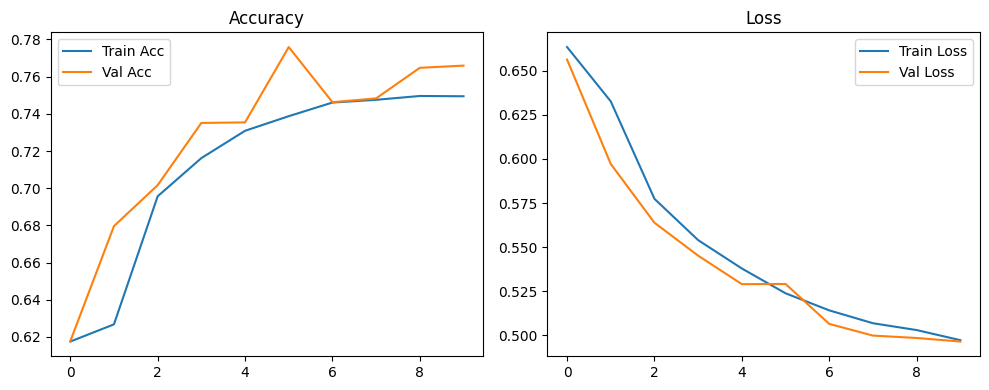

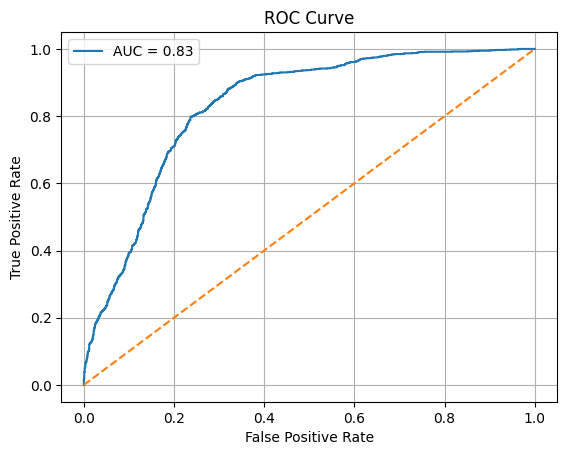

In [6]:


import os
import wfdb
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from scipy.signal import butter, filtfilt
from collections import Counter

# 1. Bandpass filter
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# 2. Z-score normalization
def zscore_normalize(signal):
    scaler = StandardScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

# 3. Preprocessing pipeline
def preprocess_ecg_windows(raw_windows, fs=100):
    processed = []
    for window in raw_windows:
        filtered = bandpass_filter(window, fs=fs)
        normalized = zscore_normalize(filtered)
        reshaped = normalized.reshape(-1, 1)
        processed.append(reshaped)
    return np.array(processed)

# 4. Load data from PhysioNet Apnea-ECG Database
def load_apnea_ecg_windows(data_path):
    record_names = [f"a{str(i).zfill(2)}" for i in range(1, 21)] + \
                   [f"b{str(i).zfill(2)}" for i in range(1, 6)] + \
                   [f"c{str(i).zfill(2)}" for i in range(1, 11)]
    data_windows = []
    labels = []
    for rec in record_names:
        try:
            base_path = os.path.join(data_path, rec)
            record = wfdb.rdrecord(base_path)
            signal = record.p_signal[:, 0]
            fs = int(record.fs)
            ann = wfdb.rdann(base_path, 'apn')
            apn_labels = ann.symbol
            total_minutes = len(signal) // (60 * fs)
            valid_minutes = min(total_minutes, len(apn_labels))
            for i in range(valid_minutes):
                start = i * 60 * fs
                end = (i + 1) * 60 * fs
                segment = signal[start:end]
                if len(segment) == 60 * fs:
                    label = 1 if apn_labels[i].strip().upper() == 'A' else 0
                    data_windows.append(segment)
                    labels.append(label)
        except Exception as e:
            print(f"Error in {rec}: {e}")
    print(f"✅ Extracted: {len(data_windows)} segments | Labels: {Counter(labels)}")
    return data_windows, labels

# 5. Define simplified MobileNetV2-like 1D CNN
class EasyMobileNetV2(tf.keras.Model):
    def __init__(self, input_shape):
        super(EasyMobileNetV2, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=input_shape)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.dwconv = tf.keras.layers.DepthwiseConv1D(3, padding='same', activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pwconv = tf.keras.layers.Conv1D(32, 1, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.dwconv(x)
        x = self.bn2(x)
        x = self.pwconv(x)
        x = self.global_pool(x)
        return self.classifier(x)

# 6. Plot Training Metrics
def plot_training(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.tight_layout()
    plt.show()

# 7. Plot ROC Curve
def plot_roc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(); plt.grid(); plt.show()

# 8. Main pipeline
if __name__ == "__main__":
    data_path = "/content/drive/MyDrive/apnea-ecg-database-1.0.0/"
    raw_windows, raw_labels = load_apnea_ecg_windows(data_path)
    X = preprocess_ecg_windows(raw_windows)
    y = np.array(raw_labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model = EasyMobileNetV2((6000, 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath='best_apnea_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    mlflow.set_experiment("EasyMobileNetV2_Apnea")
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                            validation_data=(X_test, y_test), callbacks=[checkpoint_cb])

        y_prob = model.predict(X_test).flatten()
        y_pred = (y_prob > 0.5).astype(int)

        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("AUC:", roc_auc_score(y_test, y_prob))

        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:\n", cm)

        plot_training(history)
        plot_roc(y_test, y_prob)

    # Optional: Save final model
    model.save("mobilenetv2_apnea_final.h5")
